#Тестовое задание на вакансию Аналитика в Управление клиентского сервиса

**Вводные данные**<br>
Предположим, что мы работаем аналитиком в компании N, которая предоставляет услуги широкому спектру юр и физических лиц.  В конце каждого месяца мы делаем выгрузку данных по обращениям в техническую поддержку.  Даные содержат информацию о теме обращения, дату и продолжительность разговора в секундах.

**Цель исследования**<br>
Выбрать темы, которые в первую очередь нужно брать в проработку с целью уменьшения нагрузки на техподдержку по этой теме.

**Ход исследования**<br>
Работу над проектом будем проводить в несколько этапов, а именно:<br>
- Загрузка данных и общий обзор
- Предобработка данных
- Исследовательский анализ
- Общий вывод

##Общий вывод исследования

В ходе исследования были проанализированы данные звонков в ТП, в качестве рабочего периода был взят промежуток времени с 2017-07-01 по 2017-07-31 (период активной сдачи отчетности). За это время поступали звонки по 28 различным темам. В результате анализа я установила, что 47.3% всех звонков поступило по двум темам - это "Запрос квалифицированного сертификата" (30.2%) и "Копирование контейнера. Массовое Копирование"(17.1%). Именно эти темы и стоит брать в проработку в первую очередь.
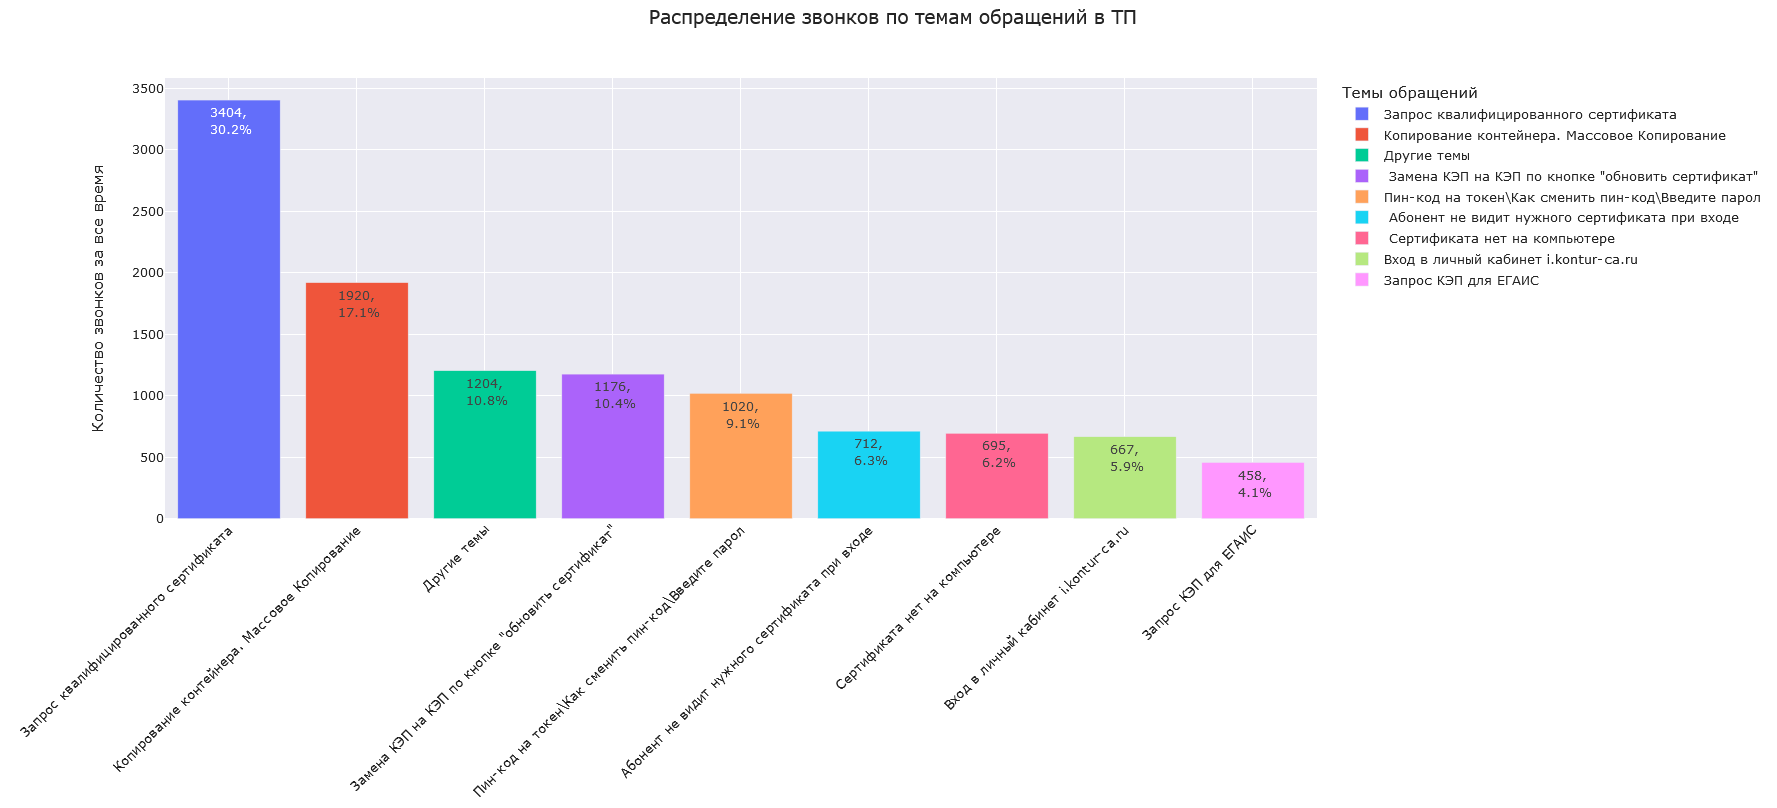

Общая тенденция звонков в ТП имеет цикличный характер, пик звонков происходит в понедельник до 750 звонков в день, к выходным почти полное затухание (в среднем до 100 звонков в день). Эта тенденция транслируется во всех темам, каких-то отдельных вспышек я не обнаружила. КЭП используется в большинстве сервисов компании, отсюда и популярность всех тем, связанных с ее обслуживанием.  
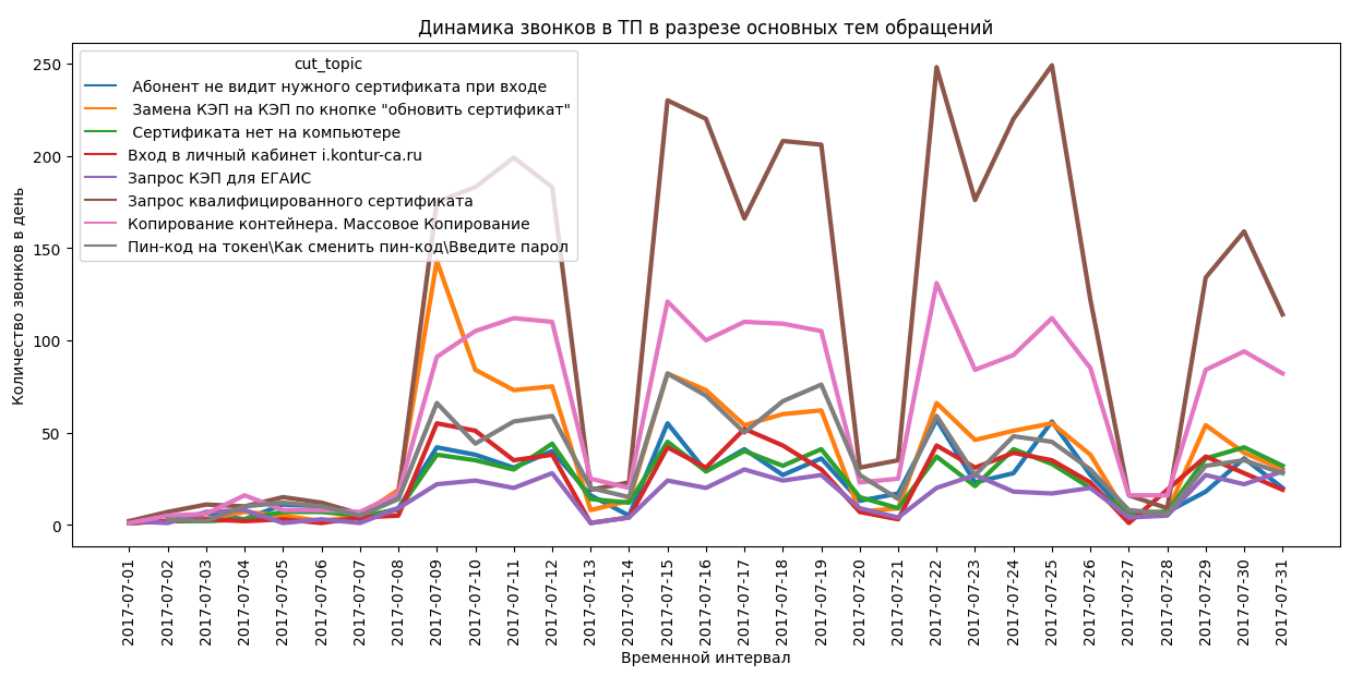

Средняя продолжительность звонков по обеим выбранным темам знаимает от 10 до 14 минут. Но стоит обратить внимание на то, что средняя продолжительность звонка по теме "Копирование контейнера. Массовое копирование" до 15 июля 2017 имела несколько пиков и была выше, чем у звонков по теме "Запрос квалифицированного сертификата". Возможно были массовые проблемы в конкретные дни, чтобы это понять - нужно посмотреть содержание обращений в пиковые дни по соответствующей теме.
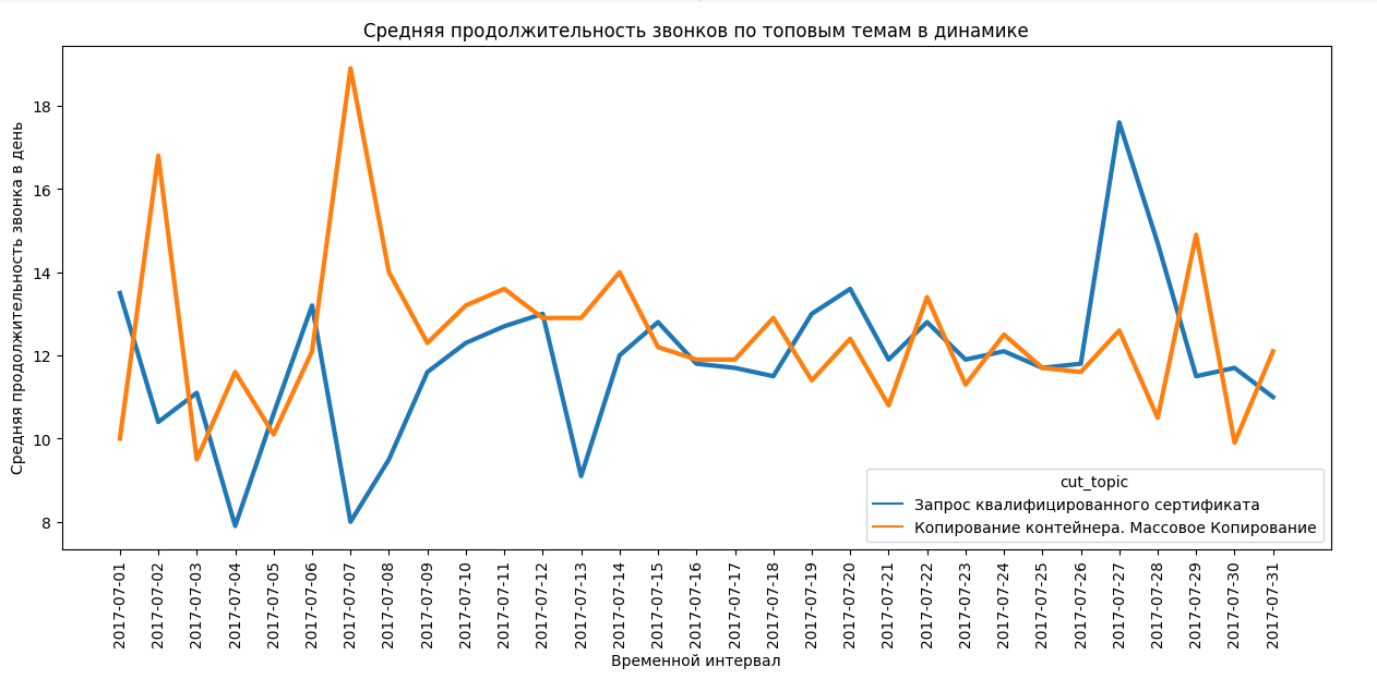

## Загрузка данных

Добавим необходимые бибилиотеки для работы и загрузим файл

In [41]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime as dt
from datetime import date
from datetime import timedelta
from matplotlib import pyplot as plt
import plotly.express as px
#from google.colab import drive
#drive.mount('drive')


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [42]:
support = pd.read_excel('#')
support.head()

,Тема,Дата,Время разговора (сек)
0,Копирование контейнера. Массовое Копирование,2017-07-12,1770
1,Запрос квалифицированного сертификата,2017-07-23,3806
2,Запрос квалифицированного сертификата,2017-07-16,254
3,Пин-код на токен\Как сменить пин-код\Введите п...,2017-07-12,456
4,Документы для получения КЭП для КЭ и КЭП для д...,2017-07-30,403


In [43]:
support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12406 entries, 0 to 12405
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Тема                   12406 non-null  object        
 1   Дата                   12406 non-null  datetime64[ns]
 2   Время разговора (сек)  12406 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 290.9+ KB


Чтобы было удобнее, переименуем колонки

In [44]:
support.columns = ['topic', 'date', 'time_speak_sek']
support.columns

Index(['topic', 'date', 'time_speak_sek'], dtype='object')

Явных пропусков нет, проверим наличие дубликатов.

In [45]:
 #проверка на явные дубликаты
support.duplicated().sum()

507

Посмотрим в каких темах чаще всего встречаются дубликаты.

In [46]:
support[support.duplicated()]['topic'].value_counts(dropna=False)

Запрос квалифицированного сертификата                                                                                                                                              313
Копирование контейнера. Массовое Копирование                                                                                                                                        81
 Замена КЭП на КЭП по кнопке "обновить сертификат"/"запросить сертификат"                                                                                                           43
Пин-код на токен\Как сменить пин-код\Введите пароль (PIN-код) для контейнера                                                                                                        29
 Абонент не видит нужного сертификата при входе                                                                                                                                     11
 Сертификата нет на компьютере                                                       

А как распределены обращения в целом?

In [47]:
support['topic'].value_counts(dropna=False)

Запрос квалифицированного сертификата                                                                                                                                              3907
Копирование контейнера. Массовое Копирование                                                                                                                                       2114
 Замена КЭП на КЭП по кнопке "обновить сертификат"/"запросить сертификат"                                                                                                          1268
Пин-код на токен\Как сменить пин-код\Введите пароль (PIN-код) для контейнера                                                                                                       1081
 Сертификата нет на компьютере                                                                                                                                                      780
 Абонент не видит нужного сертификата при входе                                 

В нашем случае подавляющая часть дубликатов была по теме "запрос квалифицированного сертификата", врядли был какой-то глобальный сбой, так как эта тема занимает лидирующее место по чисту обращений. <br>

<br> Дубликаты могут свидетельствовать о некорректности выгрузки, возможно данные   выгружали из нескольких источников. Так же можно предположить, что если бы в выгрузке был указан id клиента, то дубликатов было бы меньше. В любом случае стоит обратить на это внимание при дальнейшей выгрузке данных.  <br>

В данном датасете мы удалим дубликаты, чтобы они не создавали шум в анализе.

In [48]:
support = support.drop_duplicates().reset_index(drop=True)
print(support.duplicated().sum())
print(support.shape[0])

0
11899


## Обзор и предобработка данных

Проведем предварительный обзор данных, чтобы понимать, что исследуем.

In [49]:
support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11899 entries, 0 to 11898
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   topic           11899 non-null  object        
 1   date            11899 non-null  datetime64[ns]
 2   time_speak_sek  11899 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 279.0+ KB


### Дата обращения

In [50]:
print('В выгрузке содержатся данные с',support['date'].min(),'по', support['date'].max())

В выгрузке содержатся данные с 2016-12-12 00:00:00 по 2018-02-07 00:00:00


In [51]:
support['month']= support['date'].dt.strftime("%Y.%m")

In [52]:
support.groupby(['month'],as_index = False).agg({'topic':'count'}).sort_values(by='month').rename(columns = {'topic':'calls'})

,month,calls
0,2016.12,1
1,2017.02,1
2,2017.07,11873
3,2017.10,1
4,2017.11,1
5,2017.12,16
6,2018.02,6


Данные по обращениям есть всего лишь за 7 месяцев, не нужно строить график, чтобы заметить - пик по обращения пришелся на июль 2017, скорей всего остальные месяцы добавлены специально в рамках тестового задания. Данных по ним мало, удалим их из датасета.

In [53]:
support = support[support['date']>='2017-07-01']
support = support[support['date']<='2017-07-31']
support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11873 entries, 0 to 11898
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   topic           11873 non-null  object        
 1   date            11873 non-null  datetime64[ns]
 2   time_speak_sek  11873 non-null  int64         
 3   month           11873 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 463.8+ KB


### Темы обращения

In [54]:
print('В датасете зафиксировано',support['topic'].nunique(),'различных тем, по которым поступали обращения')

В датасете зафиксировано 28 различных тем, по которым поступали обращения


In [55]:
support['topic'].value_counts()

Запрос квалифицированного сертификата                                                                                                                                              3588
Копирование контейнера. Массовое Копирование                                                                                                                                       2030
 Замена КЭП на КЭП по кнопке "обновить сертификат"/"запросить сертификат"                                                                                                          1220
Пин-код на токен\Как сменить пин-код\Введите пароль (PIN-код) для контейнера                                                                                                       1050
 Сертификата нет на компьютере                                                                                                                                                      768
 Абонент не видит нужного сертификата при входе                                 

Наибольший интерес для нас представляют первые 5-7 тем, они явно выделяются по количеству обращений по сравнению с остальными. Все они так или иначе с выпуском ЭП, копирование контейнера, носителем, пинкодои и лампочкой на носителе.

In [56]:
#сократим описание тем до 50 символов
support['cut_topic'] = support['topic'].str.slice(0,50)
support.head()

,topic,date,time_speak_sek,month,cut_topic
0,Копирование контейнера. Массовое Копирование,2017-07-12,1770,2017.07,Копирование контейнера. Массовое Копирование
1,Запрос квалифицированного сертификата,2017-07-23,3806,2017.07,Запрос квалифицированного сертификата
2,Запрос квалифицированного сертификата,2017-07-16,254,2017.07,Запрос квалифицированного сертификата
3,Пин-код на токен\Как сменить пин-код\Введите п...,2017-07-12,456,2017.07,Пин-код на токен\Как сменить пин-код\Введите п...
4,Документы для получения КЭП для КЭ и КЭП для д...,2017-07-30,403,2017.07,Документы для получения КЭП для КЭ и КЭП для д...


### Продолжительность обращений

Округлим продолжительность разговора до минут и построим диаграмму общего распределения звонков по минутам.

In [57]:
support['time_speak_min'] = round(support['time_speak_sek'] / 60)
support.head()

,topic,date,time_speak_sek,month,cut_topic,time_speak_min
0,Копирование контейнера. Массовое Копирование,2017-07-12,1770,2017.07,Копирование контейнера. Массовое Копирование,30.0
1,Запрос квалифицированного сертификата,2017-07-23,3806,2017.07,Запрос квалифицированного сертификата,63.0
2,Запрос квалифицированного сертификата,2017-07-16,254,2017.07,Запрос квалифицированного сертификата,4.0
3,Пин-код на токен\Как сменить пин-код\Введите п...,2017-07-12,456,2017.07,Пин-код на токен\Как сменить пин-код\Введите п...,8.0
4,Документы для получения КЭП для КЭ и КЭП для д...,2017-07-30,403,2017.07,Документы для получения КЭП для КЭ и КЭП для д...,7.0


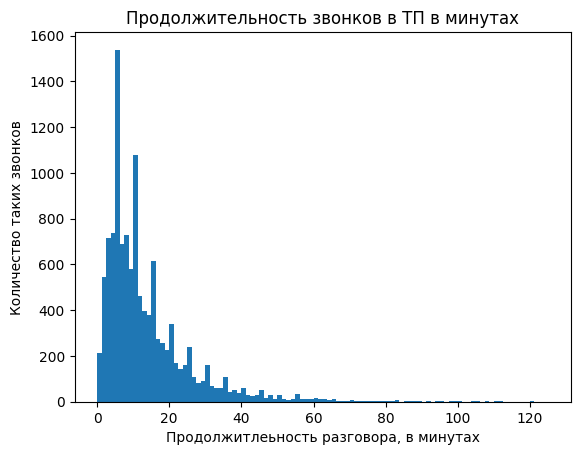

In [58]:
support['time_speak_min'].sort_values().hist(bins=100, range = (0,125));
plt.grid(False)
plt.title('Продолжительность звонков в ТП в минутах')
plt.xlabel('Продолжитлеьность разговора, в минутах') # подписи осей средствами matplotlib
plt.ylabel('Количество таких звонков') # подписи осей средствами matplotlib
plt.show();

Очевидно, что звонки, продолжительностью от 60 минут можно спокойно считать за выбросы и не учитывать их в общем анализе. Но на всякий случай построим ящик с усами, он даст более точные результаты распределения данных.

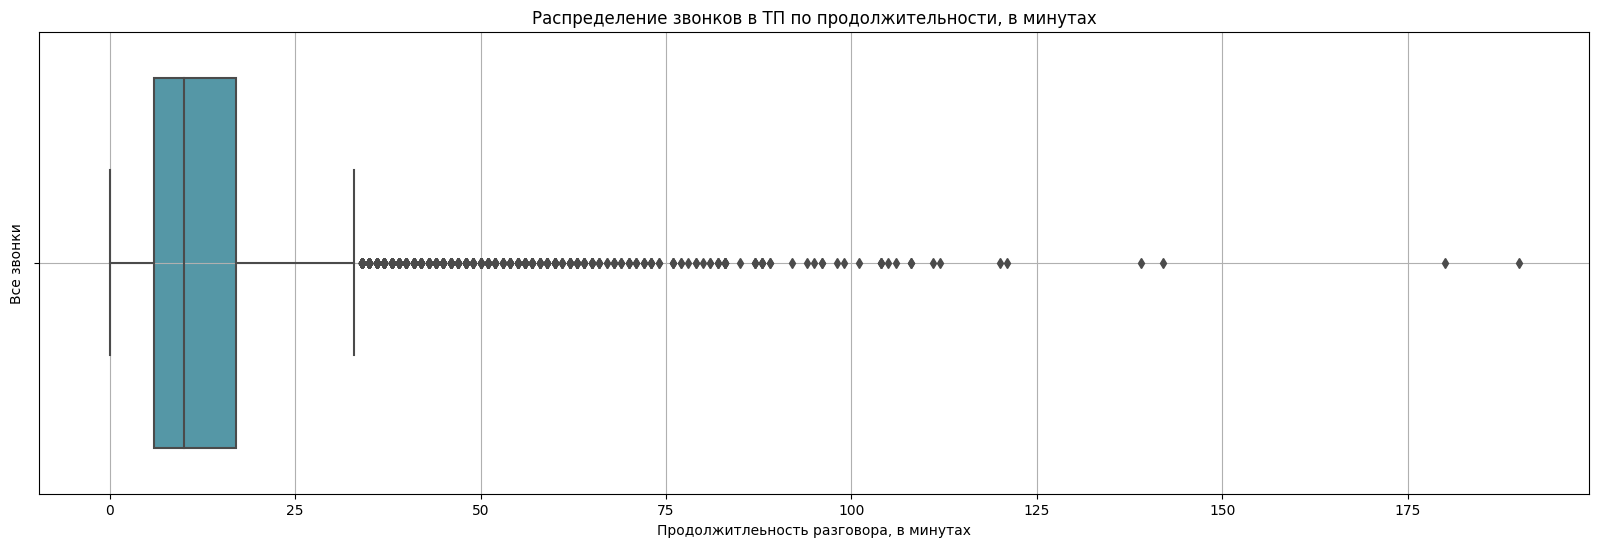

Общие показатели в цифрах:


count    11873.000000
mean        13.613493
std         12.727238
min          0.000000
25%          6.000000
50%         10.000000
75%         17.000000
max        190.000000
Name: time_speak_min, dtype: float64

In [59]:
#ящик с усами по категориям
plt.figure(figsize=(20, 6), dpi=100)
palette = sns.color_palette("Spectral_r") # PiYG
sns.boxplot(data=support, x="time_speak_min", palette = palette)
plt.grid(True)
plt.title('Распределение звонков в ТП по продолжительности, в минутах')
plt.xlabel('Продолжитлеьность разговора, в минутах') # подписи осей средствами matplotlib
plt.ylabel('Все звонки') # подписи осей средствами matplotlib
plt.show();


#Анализ выбросов
print('Общие показатели в цифрах:')
support['time_speak_min'].describe()

Итого, минимальный звонок занял меньше минуты, максимальный больше 3х часов. Посчитаем пороги усов, после которых данные можно считать за выбросы.

In [60]:
#ф-я находит границы усов
def vybros(total):
    usy = []
    usy.append(total[6] + (total[6] - total[4])*1.5)
    usy.append((total[4] - (total[6] - total[4])*1.5))

    return usy
print('Звонки, продолжительностью',vybros(support['time_speak_min'].describe())[0], 'минут, можно считать за выбросы')

Звонки, продолжительностью 33.5 минут, можно считать за выбросы


За счет округлений в минуты мы могли пропустить несколько процентов, поэтому вернемся к секундам и удалим из данных 5% самых продолжительных звонков.

In [61]:
support = support[support['time_speak_sek']<=round(np.quantile(support['time_speak_sek'], 0.95))]

Теперь проанализируем самые короткие звонки.

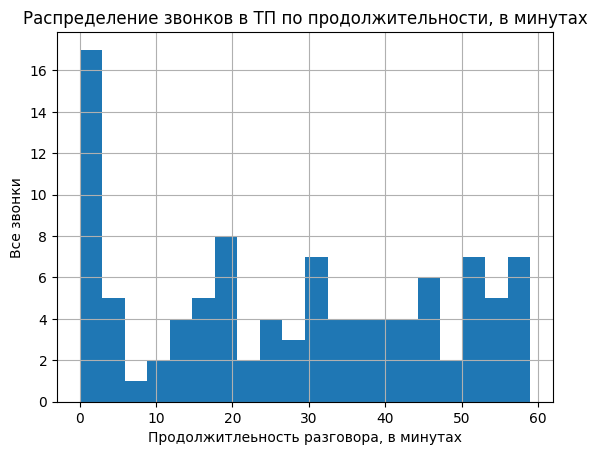

In [62]:
support[support['time_speak_sek']<60]['time_speak_sek'].hist(bins=20);
plt.grid(True)
plt.title('Распределение звонков в ТП по продолжительности, в минутах')
plt.xlabel('Продолжитлеьность разговора, в минутах') # подписи осей средствами matplotlib
plt.ylabel('Все звонки') # подписи осей средствами matplotlib
plt.show();

Звонки, продолжительностью, до 10 секунд можно точно не учитывать, это могут быть обрывы связи или автоответчик. Удалим их из датасета.

In [63]:
support = support[support['time_speak_sek']>=10]
support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11256 entries, 0 to 11898
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   topic           11256 non-null  object        
 1   date            11256 non-null  datetime64[ns]
 2   time_speak_sek  11256 non-null  int64         
 3   month           11256 non-null  object        
 4   cut_topic       11256 non-null  object        
 5   time_speak_min  11256 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 615.6+ KB


Теперь данные готовы к анализу.

## Исследовательский анализ

### Распределение тем в общем числе обращений

Посмотрим данные в разрезе темы обращений в сводной таблице - выведем кол-во звонков, их долю от всех звонков за период, ссумарное затраченное время по теме.

In [64]:
total_topic = support.groupby(['cut_topic'],as_index = False).agg({'time_speak_min':'count','time_speak_sek':'sum'}).rename(columns={'time_speak_sek':'time_sum','time_speak_min':'calls'})
total_topic['proc_calls'] =round(total_topic['calls']*100 / total_topic['calls'].sum(),1)
total_topic

,cut_topic,calls,time_sum,proc_calls
0,Абонент не видит нужного сертификата при входе,712,463951,6.3
1,"Замена КЭП на КЭП по кнопке ""обновить сертифи...",1176,763181,10.4
2,Сертификата нет на компьютере,695,555072,6.2
3,У вас на компьютере нет сертификатов,60,41230,0.5
4,Internet Explorer: приложение будет закрыто. П...,19,19866,0.2
5,UAC. Контроль учётных записей пользователей. U...,1,459,0.0
6,В контейнере закрытого ключа отсутствует откры...,51,44087,0.5
7,Введен неправильный серийный номер продукта ил...,32,24030,0.3
8,Время работы сервисного центра,1,563,0.0
9,Вход в личный кабинет i.kontur-ca.ru,667,374586,5.9


Объединим не популярные темы в одну и обновим таблицу с учетом новых показателей.

In [65]:
#ф-я заменяет название темы , если ее частота меньше 1% в общем числе обращений
def repl_topic(df):
  if df['proc_calls']<=2:
    return 'Другие темы'
  else:
    return df['cut_topic']

In [66]:
total_topic['cut_topic'] = total_topic.apply(repl_topic, axis=1)
total_topic = total_topic.groupby('cut_topic', as_index = False).agg({'calls':'sum', 'time_sum':'sum','proc_calls':'sum'}).sort_values(by='proc_calls', ascending = False).reset_index(drop=True)
total_topic['proc_calls'] = round(total_topic['proc_calls'],1).astype('str') + '%'
total_topic

,cut_topic,calls,time_sum,proc_calls
0,Запрос квалифицированного сертификата,3404,2471290,30.2%
1,Копирование контейнера. Массовое Копирование,1920,1426110,17.1%
2,Другие темы,1204,814342,10.8%
3,"Замена КЭП на КЭП по кнопке ""обновить сертифи...",1176,763181,10.4%
4,Пин-код на токен\Как сменить пин-код\Введите п...,1020,519791,9.1%
5,Абонент не видит нужного сертификата при входе,712,463951,6.3%
6,Сертификата нет на компьютере,695,555072,6.2%
7,Вход в личный кабинет i.kontur-ca.ru,667,374586,5.9%
8,Запрос КЭП для ЕГАИС,458,408202,4.1%


Выведем показали в столбчатую диаграмму для наглядности

In [67]:
#столбчатая диаграмма распределения звонков по темам
fig = px.bar(total_topic,
             x='cut_topic',
             y='calls',
             text ='proc_calls',
             color = 'cut_topic',
             labels = {'cut_topic':'Темы обращений'},
             title='Распределение звонков по темам обращений в ТП',
             height=800)
fig.update_xaxes(title_text = 'Темы обращений')
#fig.update_yaxes(hoverformat='part_test_total')

fig.update_yaxes(title_text = 'Количество звонков за все время')
fig.update_xaxes(tickangle=-45)
fig.update_layout(template='seaborn')

fig.update_traces(
    texttemplate='%{y},<br> %{text}',
    textposition='inside'
)

fig.show()

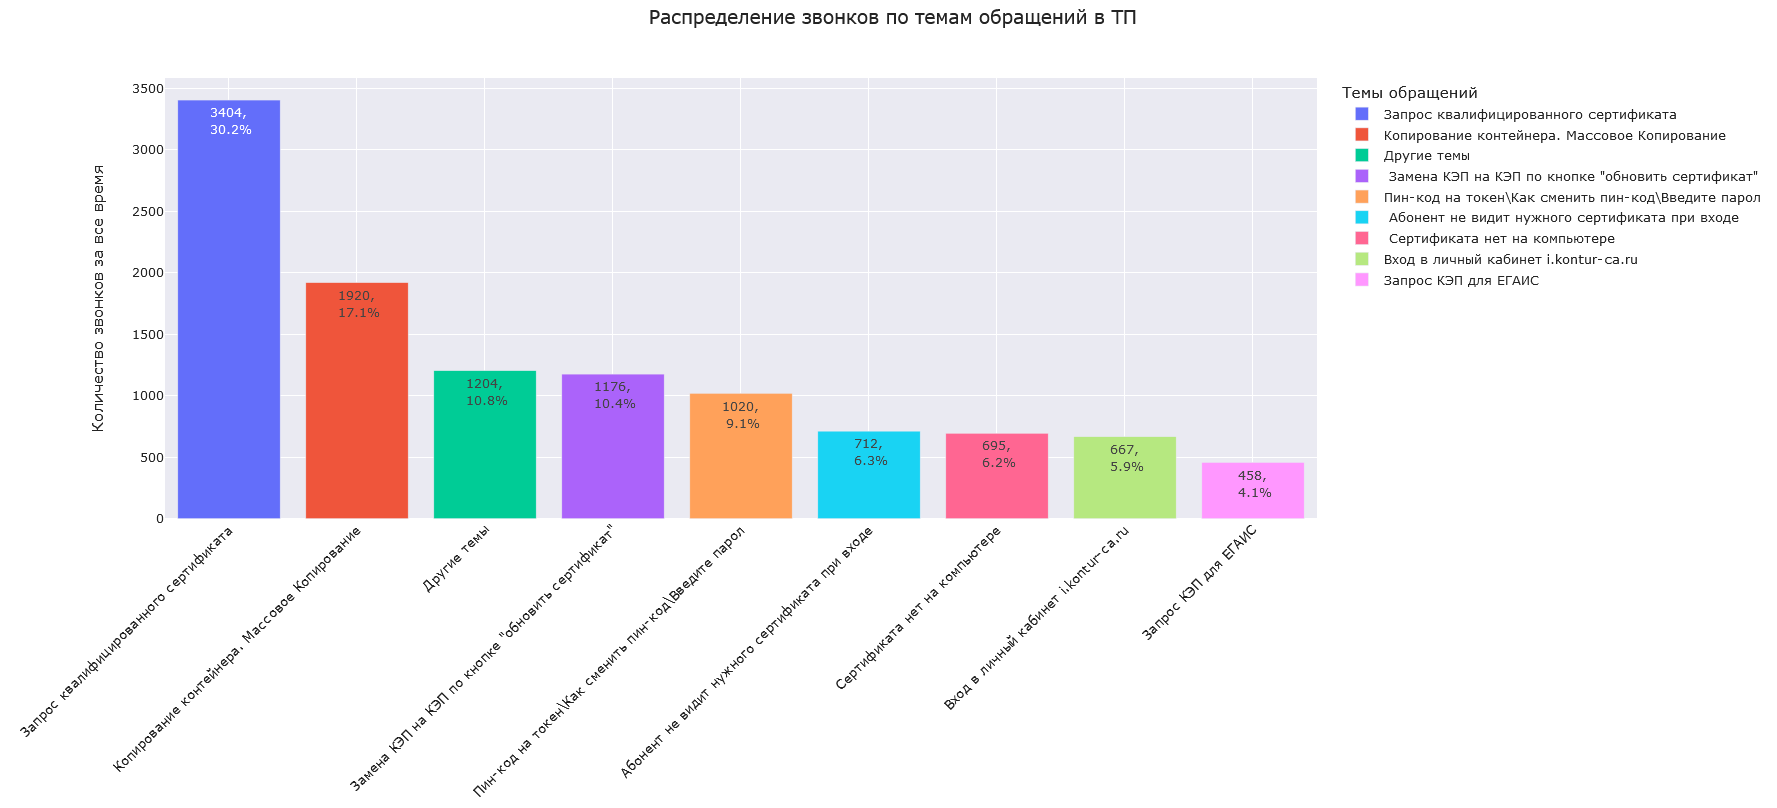

По графику очевидно, что особое внимание нужно уделитьпервым двум темам, так как звонки по ним занимают в совокупности чуть ли не 50% всех звонков в ТП. Но нужно проверить динамику, может эти темы были популярны только на ограниченном промежутке времени.

### Динамика обращений по темам

Для начала посмотрим общую картину обращений в течение июля 2017 года. Создадим сводную и посчитаем звонки по дням.

In [68]:
dau = support.groupby(['date'],as_index = False).agg({'topic':'nunique', 'time_speak_min':'count','time_speak_sek':'sum'}).sort_values(by = 'date')
dau.head()

,date,topic,time_speak_min,time_speak_sek
0,2017-07-01,7,9,5805
1,2017-07-02,10,25,18215
2,2017-07-03,12,44,31248
3,2017-07-04,12,64,45852
4,2017-07-05,11,67,43425


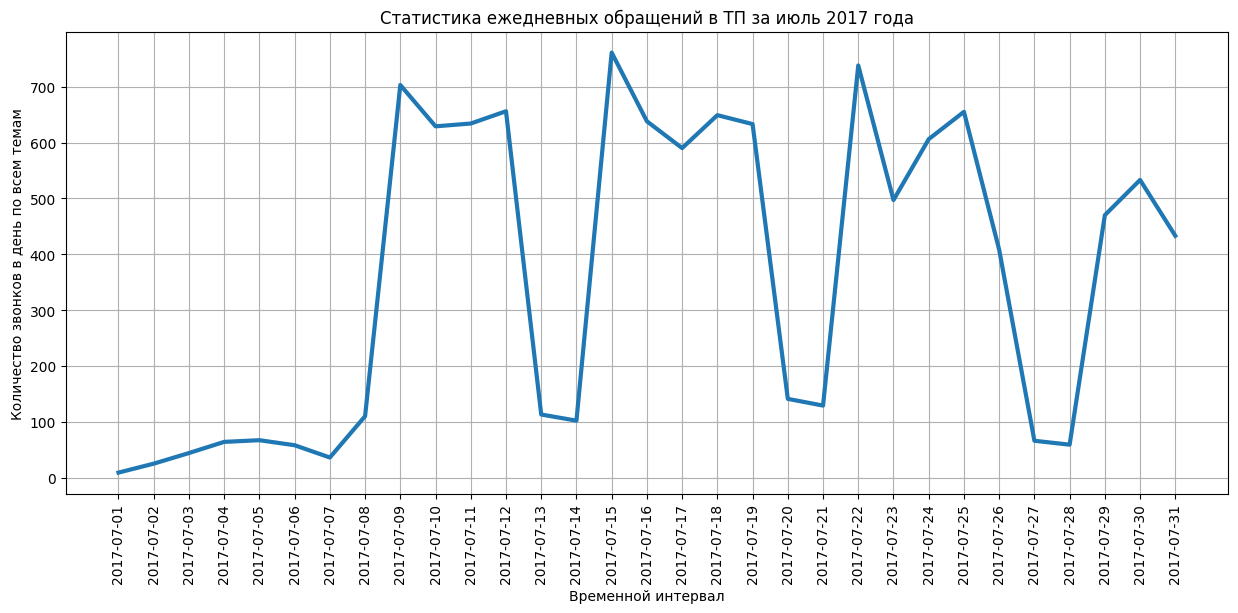

In [69]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="date", y="time_speak_min", linewidth=3, data=dau)
plt.grid()
plt.title("Статистика ежедневных обращений в ТП за июль 2017 года");
plt.xlabel('Временной интервал')
plt.ylabel('Количество звонков в день по всем темам')
plt.xticks(list(dau['date'].astype('str')));
plt.xticks(rotation=90)
plt.show();

Загруженность имееит цикличный характер, в понедельник всегда идет резкий спрос (700+ обращений), к середине недели он снижается, в пятницу второй подьем и спад до 100-150 обращений в день приходится на выходные. Если сравнивать даты с производственным календарем, то идет несовпадение (возможно данные были специально смещены в рамках задания).

Возьмем первые 8 тем по общему числу обращений и выведем динамику по числу обращений на график.Этов все темы, которые не попали в категорию "Другие темы" на предыдущем графике.

In [70]:
hot_topic_list = list(support['cut_topic'].value_counts().reset_index().head(8)['index'])

In [71]:
dau_topic = support.groupby(['cut_topic','date'],as_index = False).agg({'topic':'count','time_speak_min':'mean'}).rename(columns = {'topic':'calls','time_speak_min':'avg_time'})
dau_topic['avg_time'] = round(dau_topic['avg_time'])
dau_topic.head()

,cut_topic,date,calls,avg_time
0,Абонент не видит нужного сертификата при входе,2017-07-01,1,9.0
1,Абонент не видит нужного сертификата при входе,2017-07-02,2,6.0
2,Абонент не видит нужного сертификата при входе,2017-07-03,6,16.0
3,Абонент не видит нужного сертификата при входе,2017-07-04,3,9.0
4,Абонент не видит нужного сертификата при входе,2017-07-05,11,11.0


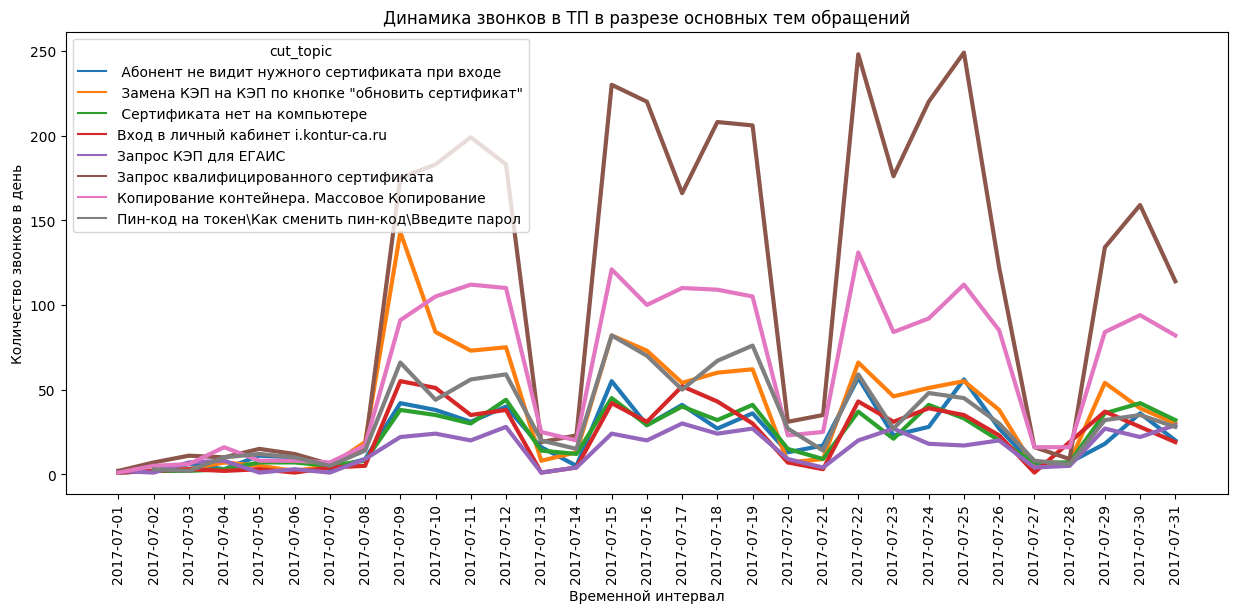

In [72]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="date", y="calls", hue = 'cut_topic', linewidth=3, data=dau_topic.query('cut_topic in @hot_topic_list'))
#plt.grid()
plt.title("Динамика звонков в ТП в разрезе основных тем обращений");
plt.xlabel('Временной интервал')
plt.ylabel('Количество звонков в день')
plt.xticks(list(dau['date'].astype('str')));
plt.xticks(rotation=90)
plt.show();

По графику видно, что по всем темам динамика обращений аналогична общему графику. Значительно вырывается вперед тема "Запрос квалифицированного сертификата". После него идет "Копирование контейнера. Массовое копирование". Во второй неделе был доп.спрос на тему "ЗАмена КЭП по кнопке "обновить сертификат". Остальные темы лавируют между собой от недели к неделе.

На 4 неделе число обращений идет на спад, скорей всего это говорит о том, что сроки сдачи отчетности подходят к концу. Очевидно, что оброащения поступают по всем темам в отчетный период, на графике не заметны всплески отдельных тем в какие-то избранные дни, значит глобальных сбоев в системе не было.

### Продолжительность звонков

Теперь посмотрим среднюю продолжительность звонка по каждой из 8 выбранных тем.

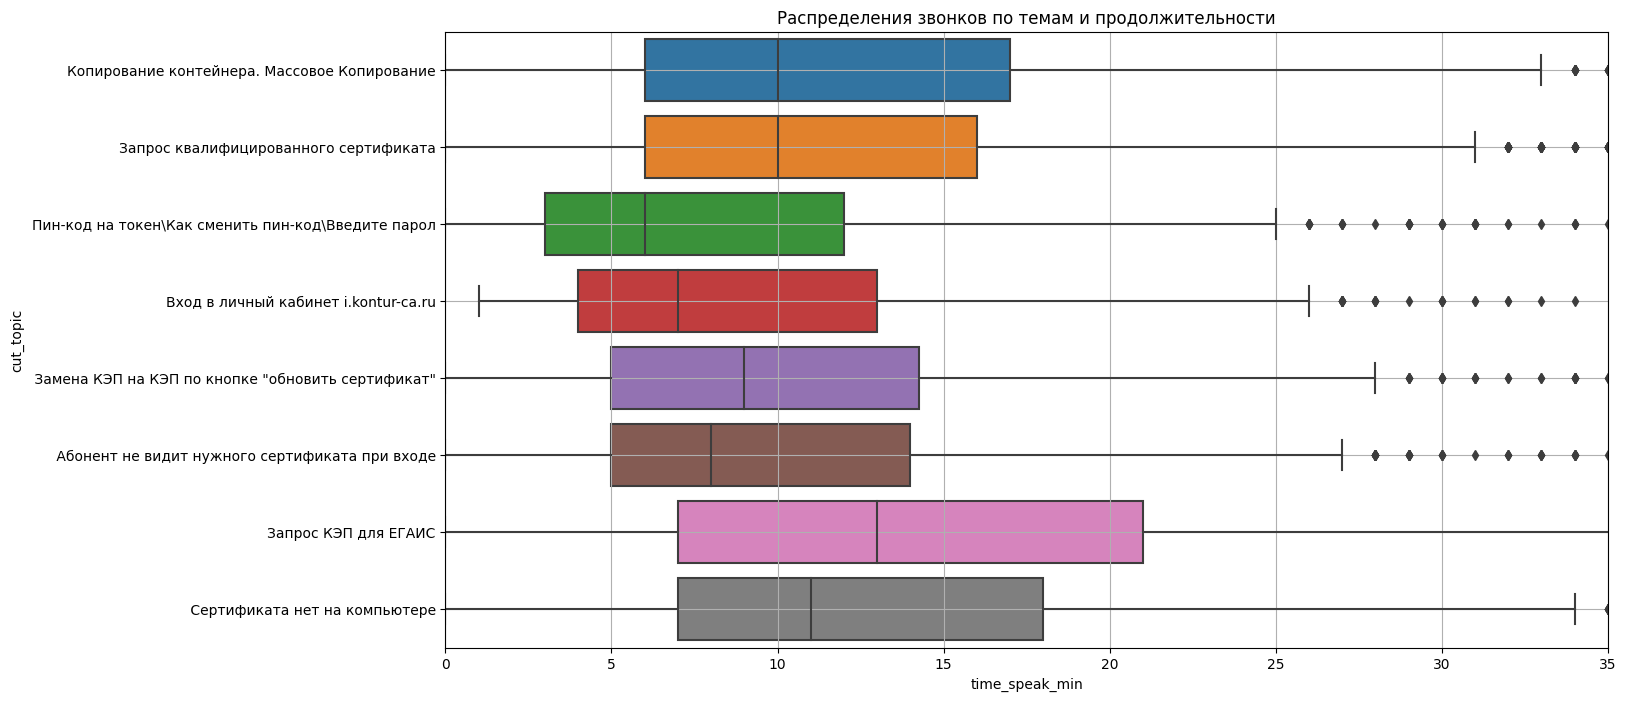

In [73]:
fig = plt.subplots(figsize=(15, 8))
sns.boxplot(data =support.query('cut_topic in @hot_topic_list'),  x='time_speak_min', y = 'cut_topic');
plt.grid()
plt.xlim(0,35)
plt.title("Распределения звонков по темам и продолжительности");

Среди выбранных тем самой продолжительные разговоры наблюдаются в теме "Запрос КЭП для ЕГАИС". Возможно там не настолько отлаженный механизм, в любом случае эта тебя берет на себя только 4,1% всех звонков, а значит пока не представляет для нас интереса. Основная часть звонков по другим темам укладывается в 20 минут.Выведем тот же график, но уже для всех тем.

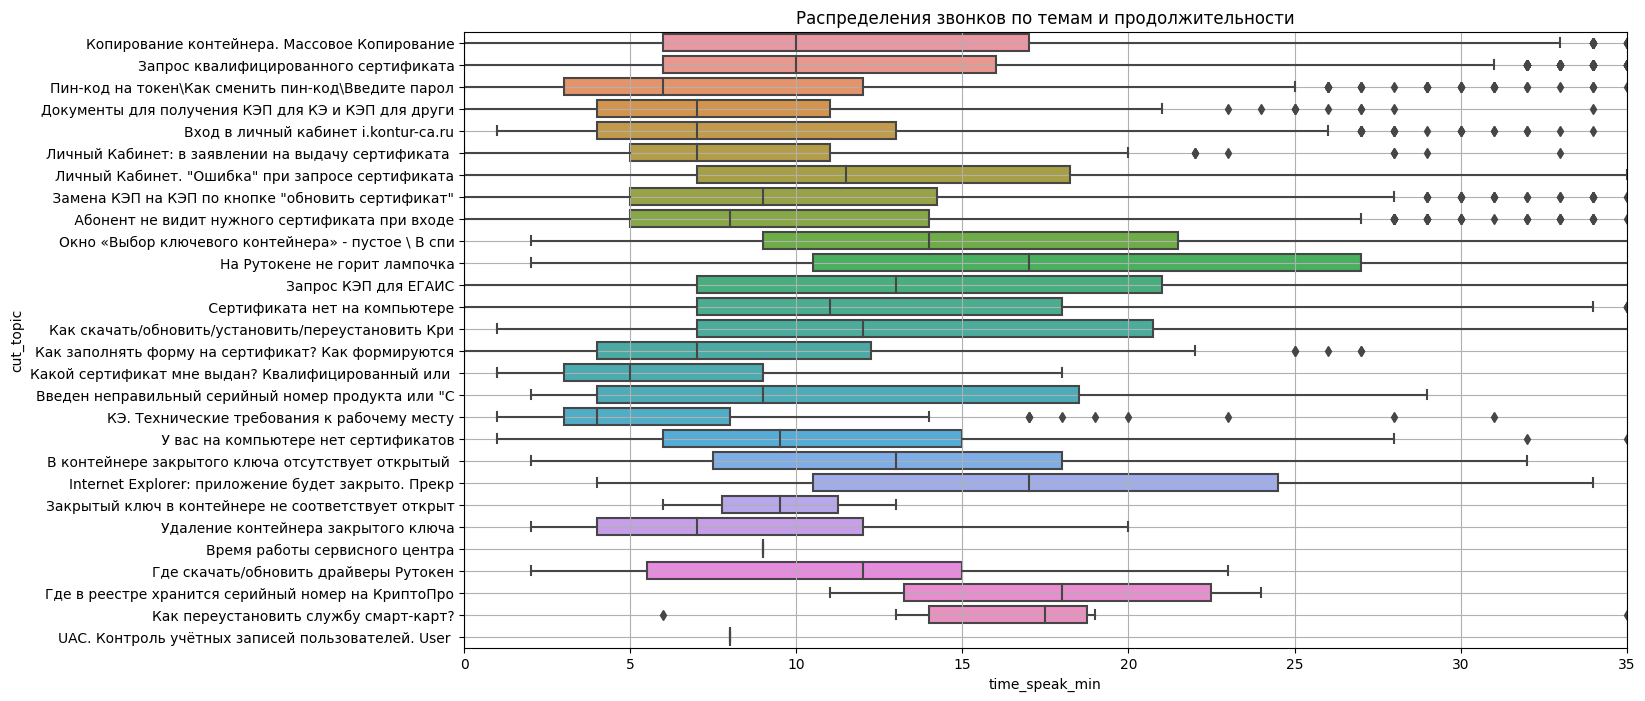

In [74]:
fig = plt.subplots(figsize=(15, 8))
sns.boxplot(data =support,  x='time_speak_min', y = 'cut_topic');
plt.grid()
plt.xlim(0,35)
plt.title("Распределения звонков по темам и продолжительности");

А вот тут есть явные лидеры. Больше всего времени (до 23 минут) уходит на решение вопроса "на рутокене не горит лампочка" и вопросы "Где в реестре хранится серийный номер крипто про". Тем не менее, обращения по этим темам случаются относительно редко и составляют меньше 2% каждая.

В самом начале мы определили два самые популярные темы, посмотрим как меняется среднее время звонок по ним в динамике июля 2017 года.



In [75]:
dau_avg_time = support.groupby(['cut_topic','date'],as_index = False).agg({'time_speak_min':'mean'}).sort_values(by = ['cut_topic','date'])
dau_avg_time['time_speak_min'] = round(dau_avg_time['time_speak_min'],1)
dau_avg_time

,cut_topic,date,time_speak_min
0,Абонент не видит нужного сертификата при входе,2017-07-01,9.0
1,Абонент не видит нужного сертификата при входе,2017-07-02,5.5
2,Абонент не видит нужного сертификата при входе,2017-07-03,15.8
3,Абонент не видит нужного сертификата при входе,2017-07-04,9.3
4,Абонент не видит нужного сертификата при входе,2017-07-05,11.1
...,...,...,...
511,Удаление контейнера закрытого ключа,2017-07-23,9.0
512,Удаление контейнера закрытого ключа,2017-07-24,3.0
513,Удаление контейнера закрытого ключа,2017-07-26,20.0
514,Удаление контейнера закрытого ключа,2017-07-30,3.0


Выведем результаты по двум темам на график.



In [76]:
hot_topic = list(support['cut_topic'].value_counts().reset_index().head(2)['index'])

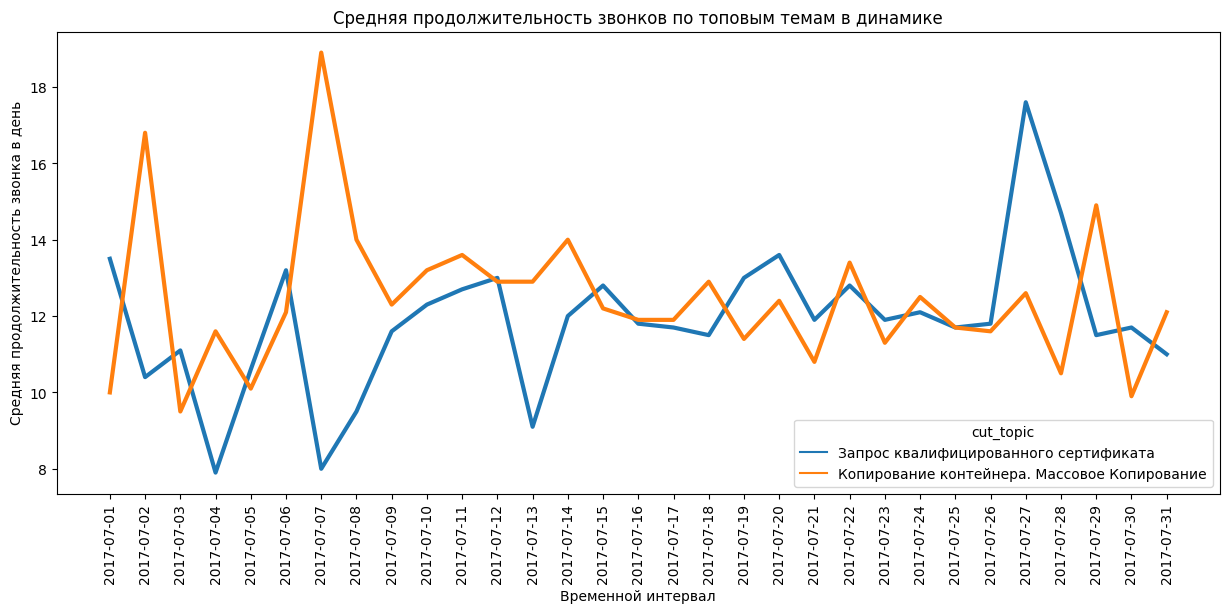

In [77]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="date", y="time_speak_min", hue = 'cut_topic', linewidth=3, data=dau_avg_time.query('cut_topic in @hot_topic'))
#plt.grid()
plt.title("Средняя продолжительность звонков по топовым темам в динамике");
plt.xlabel('Временной интервал')
plt.ylabel('Средняя продолжительность звонка в день')
plt.xticks(list(dau['date'].astype('str')));
plt.xticks(rotation=90)
plt.show();

В период с 1 по 15 июля 2017 заметно, что звонки связанные с копированием сертификата занимают в среднем больше времени, более того 2 и 7 июля видны пики, это может свидетельствовать о какой-то проблеме в эти дни. потом графики выравниваются и идут совместно, под конец период наблюдается небольшой всплеск по обемих темам. Таким образом в среднем состоянии звонок занимает от 10 до 14 минут. В пиковых - до 20 минут.

На этом я закончила исследование, с его общим выводом можно ознакомиться вначале документа.